## Preparación del entorno.

Si no estamos parados en el repo, clonar y cd al repo. Esto nos permite usar el mismo notebook tanto local como en Google Colab.

In [1]:
import os

REPO_NAME = "AAII-Lab7"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/MiguelMussi/{REPO_NAME}.git
  os.chdir(REPO_NAME)


Cloning into 'AAII-Lab7'...
remote: Enumerating objects: 3029, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 3029 (delta 1), reused 6 (delta 0), pack-reused 3019
Receiving objects: 100% (3029/3029), 66.90 MiB | 13.44 MiB/s, done.
Resolving deltas: 100% (1/1), done.


Importar librerías

In [2]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, Dense, GlobalMaxPooling2D
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from PIL import Image
import cv2

Establecer GPU por defecto en caso de estar disponible.

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


Cargar dataset:

In [4]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("dataset/train")
VALIDATION_DATA_DIRECTORY = Path("dataset/validation")

# Tamaño del lote (batch size)
BATCH_SIZE = 32
# Tamaño de las imágenes
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Inspeccionar las clases:

In [5]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['cats', 'dogs']


Reducimos el tamaño del dataset para emular un escenario real donde no tenemos muchos datos.

In [6]:
train_ds = train_ds.take(200)
val_ds = val_ds.take(100)

Visualizar los datos:

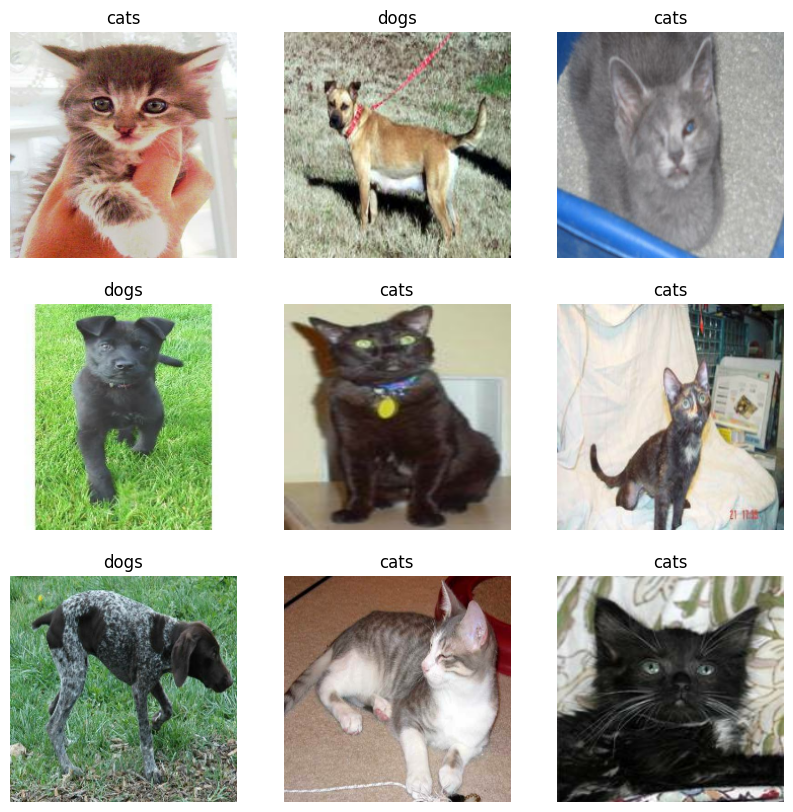

In [8]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

Definir la arquitectura de la red:

In [9]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

Construir el modelo:

In [10]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
16705208/16705208 [==============================] - 0s 0us/step


Resumen del modelo:

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 4052133 (15.46 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


Entrenar el modelo:

In [13]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint_acc = ModelCheckpoint(
    "model-e{epoch:02d}-loss{val_loss:.3f}-acc{val_accuracy:.3f}",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.7,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc, reduce_lr, early_stopping],
)


Epoch 1/10
63/63 [==============================] - 51s 673ms/step - loss: 0.2463 - accuracy: 0.9295 - val_loss: 0.0767 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 7s 114ms/step - loss: 0.0348 - accuracy: 0.9865 - val_loss: 0.0629 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 7s 101ms/step - loss: 0.0212 - accuracy: 0.9925 - val_loss: 0.0774 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 38s 606ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.0597 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 5/10
63/63 [==============================] - 10s 134ms/step - loss: 0.0099 - accuracy: 0.9975 - val_loss: 0.0841 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 6/10
63/63 [==============================] - 37s 584ms/step - loss: 0.0104 - accuracy: 0.9960 - val_loss: 0.0546 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 7/10
63/63 [==============================] - 40s 632ms/step

Visualizar resultados de entrenamiento:

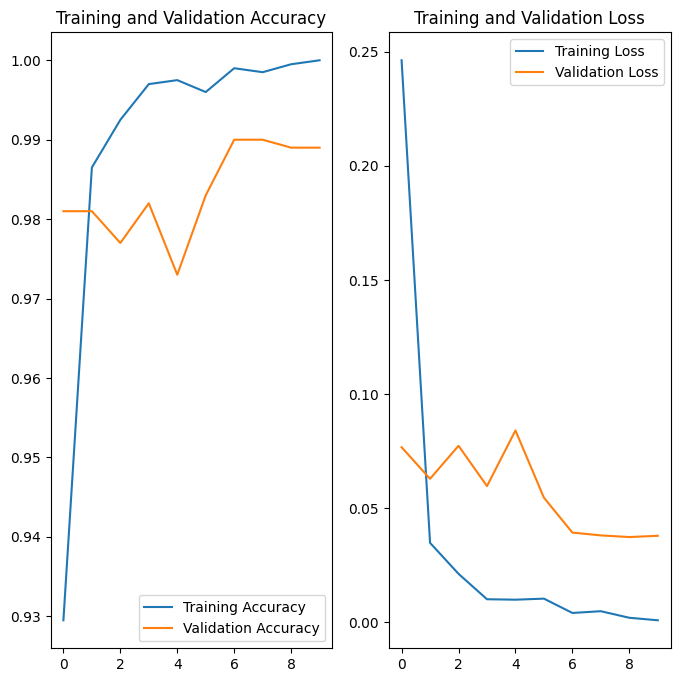

In [14]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Algoritmo de clasificacion:

In [15]:
def classify_img(img):
    img_pred = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)  # Convert head crop to RGB format
    img_pred = cv2.resize(img_pred, (IMAGE_WIDTH, IMAGE_WIDTH))  # Resize the image
    img_pred = np.expand_dims(img_pred, axis=0)  # Expand dimensions to create batch
    predictions = model(img_pred)  # Perform hat classification
    predicted_score = np.max(predictions) # Get the max score
    predicted_class_index = np.argmax(predictions)  # Get index of predicted class
    predicted_class = class_names[predicted_class_index]  # Get predicted class
    return predicted_class, predicted_score # Return predicted hat class

Algoritmo de ventana deslizante con tamaño fijo:

In [16]:
def sliding_window(image, step_size, window_size):
    """
    Genera regiones de una imagen utilizando el algoritmo de ventana deslizante.

    Args:
        image: Imagen de entrada.
        step_size: Tamaño del paso para desplazar la ventana.
        window_size: Tamaño de la ventana (altura, ancho).

    Returns:
        Una lista de tuplas (x, y, ventana) donde (x, y) es la esquina superior izquierda
        de la ventana y ventana es la región de la imagen cubierta por la ventana.
    """
    windows = list()
    # Itera sobre las coordenadas (x, y) de la imagen con el paso especificado
    for y in range(0, image.shape[0] - window_size[0] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[1] + 1, step_size):
            # Define la región de la imagen cubierta por la ventana
            crop = image[y:y+window_size[0], x:x+window_size[1]]
            # Aplica el modelo de clasificacion
            predicted_class, predicted_score = classify_img(crop)
            # Crea la tupla window = (x, y, w, h, class, score)
            window = (x, y, window_size[1], window_size[0], predicted_class, predicted_score)
            windows.append(window)
    return windows

Algoritmo de ventana deslizante con tamaño variable:

In [17]:
def sliding_window_variable(image):
    """
    Genera todas las regiones posibles de una imagen utilizando iteradamente el algoritmo de ventana deslizante,
    con rangos máximos para el tamaño y la relación de aspecto.

    Args:
        image: Imagen de entrada.

    Returns:
        Una lista de tuplas (x, y, w, h, class, score) donde (x, y) es la esquina superior izquierda
        de la ventana, w y h son el ancho y alto de la ventana, respectivamente, y class y score son
        la clase predicha y la puntuación correspondiente para esa ventana.
    """
    windows = []
    # Tamaño de la ventana e incremento
    max_window_size = min(image.shape[0], image.shape[1])
    min_windows_size = 100
    size_delta = 50
    # Relación de aspecto
    max_aspect_ratio = 2.0
    min_aspect_ratio = 0.5
    aspect_ratio_delta = 0.5

    for window_size in range(min_windows_size, max_window_size + 1, size_delta):  # Ventana desde el min a max con paso de delta
        for aspect_ratio in np.arange(min_aspect_ratio, max_aspect_ratio, aspect_ratio_delta):  # Relación de aspecto desde min hasta max con paso de delta
            for y in range(0, image.shape[0] - window_size + 1):
                for x in range(0, image.shape[1] - int(window_size * aspect_ratio) + 1):
                    # Define la región de la imagen cubierta por la ventana
                    crop = image[y:y+window_size, x:x+int(window_size * aspect_ratio)]
                    # Aplica el modelo de clasificación
                    predicted_class, predicted_score = classify_img(crop)
                    # Crea la tupla window = (x, y, w, h, class, score)
                    window = (x, y, int(window_size * aspect_ratio), window_size, predicted_class, predicted_score)
                    windows.append(window)

    return windows

Algoritmo NMS:

In [ ]:
def nms(windows, threshold):
    """
    Aplica el algoritmo de supresión de no máximos (NMS) a las ventanas.

    Args:
        windows: Lista de tuplas que representan las ventanas, cada tupla en el formato (x, y, w, h, class, score).
        threshold: Umbral de solapamiento para decidir si dos ventanas deben suprimirse.

    Returns:
        Una lista de ventanas después de aplicar NMS.
    """

In [18]:
def nms(windows, threshold):
    """
    Aplica el algoritmo de supresión de no máximos (NMS) a las ventanas.

    Args:
        windows: Lista de tuplas que representan las ventanas, cada tupla en el formato (x, y, w, h, class, score).
        threshold: Umbral de solapamiento para decidir si dos ventanas deben suprimirse.

    Returns:
        Una lista de ventanas después de aplicar NMS.
    """
    # Ordenar las ventanas por puntaje de mayor a menor
    windows.sort(key=lambda x: x[5], reverse=True)

    # Lista para almacenar las ventanas después de NMS
    nms_windows = []

    while windows:
        # Tomar la ventana con el mayor puntaje
        max_window = windows.pop(0)
        nms_windows.append(max_window)

        # Calcular área de la ventana máxima
        x1_max, y1_max, w_max, h_max, _, _ = max_window
        x2_max, y2_max = x1_max + w_max, y1_max + h_max
        area_max = w_max * h_max

        # Inicializar lista para almacenar índices de ventanas para eliminar
        to_remove = []

        # Comparar la ventana máxima con las restantes
        for i, window in enumerate(windows):
            x1, y1, w, h, _, _ = window
            x2, y2 = x1 + w, y1 + h

            # Calcular área de intersección
            x_overlap = max(0, min(x2, x2_max) - max(x1, x1_max))
            y_overlap = max(0, min(y2, y2_max) - max(y1, y1_max))
            overlap_area = x_overlap * y_overlap

            # Calcular área de la ventana actual
            area = w * h

            # Calcular solapamiento como fracción del área de la ventana actual
            overlap_ratio = overlap_area / min(area, area_max)

            # Si el solapamiento es mayor que el umbral, marcar ventana para eliminación
            if overlap_ratio > threshold:
                to_remove.append(i)

        # Eliminar las ventanas marcadas para eliminación de la lista de ventanas
        for index in sorted(to_remove, reverse=True):
            del windows[index]

    return nms_windows


Algoritmo para dibujar detecciones:

In [ ]:
def draw_bboxes(filtered_windows, image):
    """
    Dibuja los bounding boxes de las ventanas filtradas con su clase sobre la imagen.

    Args:
        filtered_windows: Lista de tuplas que representan las ventanas, cada tupla en el formato (x, y, w, h, class, score).

    Returns:
        Una imagen con los bouding boxes y sus respectivas clases.
    """

In [19]:
def draw_bboxes(filtered_windows, image):
    """
    Dibuja los bounding boxes de las ventanas filtradas con su clase sobre la imagen.

    Args:
        filtered_windows: Lista de tuplas que representan las ventanas, cada tupla en el formato (x, y, w, h, class, score).
        image: Imagen sobre la que se dibujarán los bounding boxes.

    Returns:
        Una imagen con los bounding boxes y sus respectivas clases.
    """
    # Crear una copia de la imagen para no modificar la original
    image_with_boxes = image.copy()

    # Diccionario de colores para las clases
    class_colors = {
        "dog": (0, 255, 0),  # Verde para la clase "perro"
        "cat": (255, 0, 0)   # Azul para la clase "gato"
        # Agrega más colores si hay más clases
    }

    # Dibujar bounding boxes para cada ventana filtrada
    for window in filtered_windows:
        x, y, w, h, class_name, _ = window
        color = class_colors.get(class_name, (0, 0, 255))  # Rojo por defecto si la clase no tiene un color asignado
        # Dibujar el bounding box con el color correspondiente
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)
        # Escribir la clase sobre el bounding box
        cv2.putText(image_with_boxes, class_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    return image_with_boxes


Implementacion final:
 - Comparar resultados de sliding window con tamaño fijo para distintos valores de step_size y window_size.
 - Comparar resultados de sliding window con tamaño fijo y variable.
 - Aplicar NMS sobre los resultados del sliding window con tamaño variable.

En todos los casos aplicar un treshold de score sobre las windows y dibujar las detecciones sobre las imagenes.
Utilizar como imagenes de entrada las que se encuentran en la carpeta ./detection-test-images/

In [ ]:
for image_path in image_paths:
        # Cargar la imagen
        image = cv2.imread(image_path)

        # Aplicar sliding window con tamaño fijo para distintos valores de step_size y window_size
        # for step_size, window_size in combinaciones:
        #     windows = sliding_window(image, step_size, window_size)
        #     filtered_windows = aplicar_threshold(windows)
        #     dibujar_detenciones(image, filtered_windows)
        #     mostrar_resultados(image)

        # Aplicar sliding window con tamaño fijo y variable
        # fixed_windows = sliding_window(image, step_size, window_size)
        # variable_windows = sliding_window_variable(image)
        # filtered_fixed_windows = aplicar_threshold(fixed_windows)
        # filtered_variable_windows = aplicar_threshold(variable_windows)
        # dibujar_detenciones(image, filtered_fixed_windows)
        # dibujar_detenciones(image, filtered_variable_windows)
        # mostrar_resultados(image)

        # Aplicar NMS sobre los resultados del sliding window con tamaño variable
        # nms_windows = nms(variable_windows, threshold)
        # filtered_nms_windows = aplicar_threshold(nms_windows)
        # dibujar_detenciones(image, filtered_nms_windows)
        # mostrar_resultados(image)
